# Motivation

You might be thinking about developing a new app, simply looking at how your competitors are doing or getting so many reviews that it is hard to make sense of them. You surely have a well-specified category/niche for your app. And with the presence of Google Play and other app markets a lot of user opinions about similar apps.

What the users want? What they dislike about your competitor apps? Which features are really useful and which are a waste of time? What keywords and phrases your users use? What words can you use to make meaningful conversations with them?

All good questions and some more hard to answer than others. The following analysis might not be enough for your needs rather just a starting point for you to expand on. Note that the provided dataset is somewhat limited and collected with todo apps in mind. Feel free to use app reviews from other categories/niches.

Shall we?

# Methodology

A total of 11518 reviews were collected from 30 productivity apps on Google Play. 5 pages of reviews sorted by helpfulness and 5 pages of reviews sorted by newest were collected per app. Some duplicates are present in the dataset.

The chosen apps are some of the most famous todo & calendar apps on the market. Detailed list of the apps is provided further below. All of them have 10,000+ downloads at the time of this writing.

The dataset is *NOT* provided since it is not clear whether or not it is ok to do so :) Feel free to write me if you need more information (or the source code) about scraping the reviews.

Most of the heavy lifting is done by the Latent Dirichlet Allocation (LDA) algorithm - Bayesian hierarchical model (used for unsupervised learning). We will use LDA to find topics (commonly occurring keywords) in the user comments.

# Required packages

You will need the following packages (along with their respective versions) to follow along. All of them are installable using ```pip install ...```

In [65]:
%load_ext watermark

In [66]:
%watermark -v -p numpy,scipy,seaborn,matplotlib,pyLDAvis,scikit-learn,pandas,nltk,networkx

CPython 3.5.1
IPython 4.2.0

numpy 1.11.1
scipy 0.17.1
seaborn 0.7.1
matplotlib 1.5.1
pyLDAvis 2.0.0
scikit-learn 0.17.1
pandas 0.18.1
nltk 3.2.1
networkx 1.11


# Preprocessing the data

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from pylab import rcParams
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='ticks', palette='Spectral', font_scale=1.5)

material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8

plt.xkcd();
random_state = 42
np.random.seed(random_state);

In [2]:
df = pd.read_csv("data/reviews.csv", header=None, parse_dates=[7])

In [3]:
df.columns = ["app_package", "data_review_id", "review_id", "author", "title", "comment", "rating", "date"]
df['comment_word_count'] = df.comment.apply(lambda x: len(x.split(" ")) if isinstance(x, str) else 0)
df.drop('author', axis=1, inplace=True)

In [4]:
df.head()

,app_package,data_review_id,review_id,title,comment,rating,date,comment_word_count
0,com.habitrpg.android.habitica,AOqpTOFemHosa180DA6f_t-E30EedvZVEB8oVFYfPImQTj...,Z3A6QU9xcFRPRmVtSG9zYTE4MERBNmZfdC1FMzBFZWR2Wl...,NaN,NaN,5,2016-06-25,0
1,com.habitrpg.android.habitica,AOqpTOH1MxljvMXXYB0FMTm6ebi7uV45tYUcgc1kba8lh4...,Z3A6QU9xcFRPSDFNeGxqdk1YWFlCMEZNVG02ZWJpN3VWND...,My new favorite,I always get what I need done and met the best...,5,2016-06-25,12
2,com.habitrpg.android.habitica,AOqpTOHYrX0vzM7bBC9v5NvhMMzwTkP2flwB4bgm1SHj5H...,Z3A6QU9xcFRPSFlyWDB2ek03YkJDOXY1TnZoTU16d1RrUD...,For the passionate gamer,A check list that does more then just check th...,5,2016-06-25,77
3,com.habitrpg.android.habitica,AOqpTOHRcl9CYt_KCDkRcvvtZ9kD9dqbKo1DWnyEkZYI_n...,Z3A6QU9xcFRPSFJjbDlDWXRfS0NEa1JjdnZ0WjlrRDlkcW...,NaN,NaN,4,2016-06-25,0
4,com.habitrpg.android.habitica,AOqpTOFEuiOv5BdvlMoXF_-Kj4HDWN02uGgmQVGn8jrzJK...,Z3A6QU9xcFRPRkV1aU92NUJkdmxNb1hGXy1LajRIRFdOMD...,NaN,NaN,3,2016-06-25,0


In [7]:
df.drop_duplicates('data_review_id', inplace=True)
rating_only_count = len(df[df.comment_word_count == 0])
df.drop_duplicates('comment', inplace=True)
rating_with_review_count = len(df[df.comment_word_count > 0])
df = df.sample(frac=1)

# Exploration

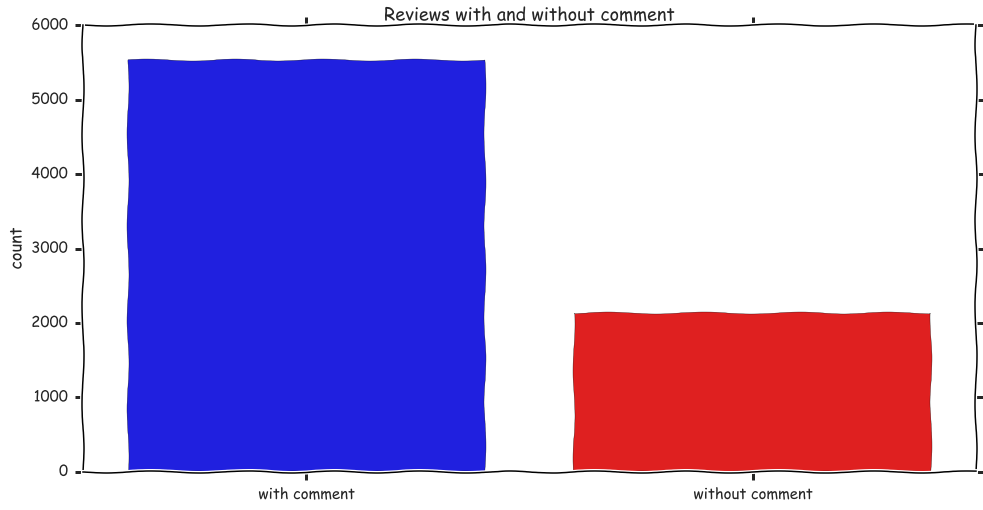

In [8]:
sns.barplot(x=['with comment', 'without comment'], y = [rating_with_review_count, rating_only_count]);
plt.title("Reviews with and without comment");
plt.ylabel("count");

How many apps and which exactly?

In [9]:
print(len(df.app_package.unique()))
from IPython.core.display import display, HTML
for app_package in df.app_package.unique():
    display(HTML('<a href="https://play.google.com/store/apps/details?id=' + app_package + '" target="_blank">' + app_package + '</a>'))

30


How many non duplicate reviews?

In [10]:
df.shape

(5541, 8)

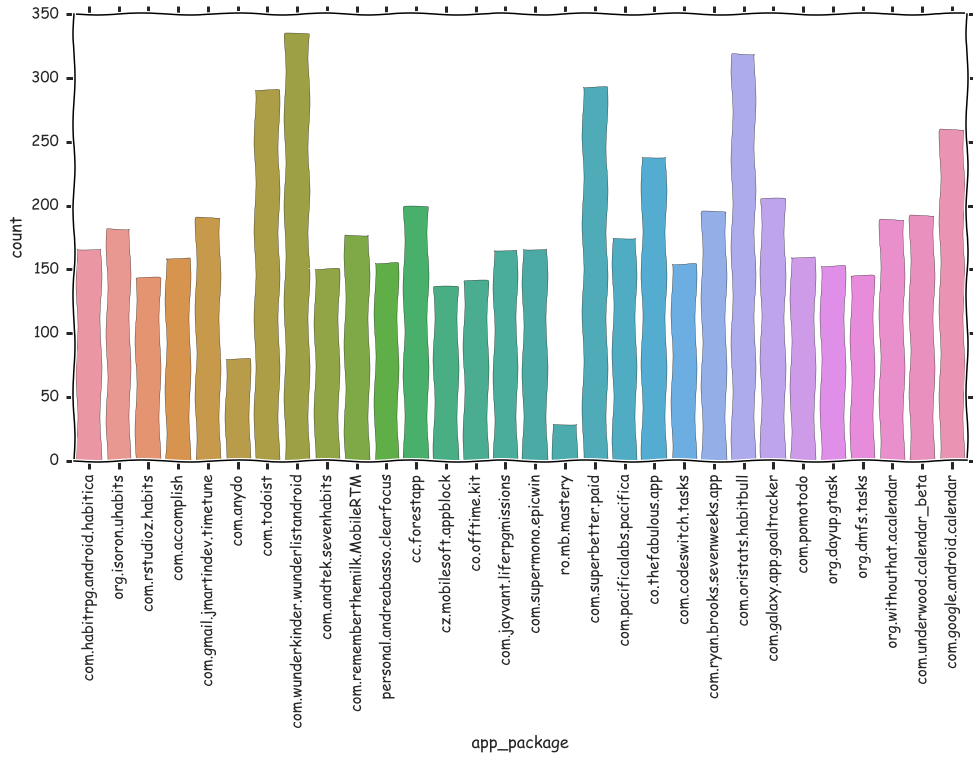

In [11]:
sns.countplot(df.app_package)
plt.xticks(rotation=90);

In [12]:
def plot_mean_rating_over_last_10_months(df, title = ""):
    recent = df[(df['date'] > '2015-10-01') & (df['date'] < '2016-08-01')]
    recent.groupby('date').rating.mean().plot()
    plt.xticks(rotation=90);
    if title:
        plt.title(title);

Let's check what the ratings for the Wunderlist app look like

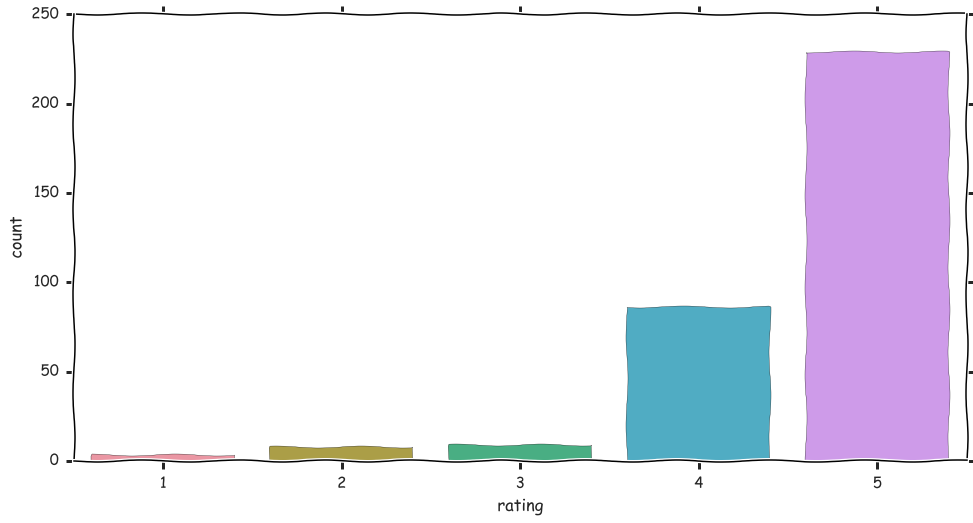

In [13]:
wunderlist = df[df.app_package == 'com.wunderkinder.wunderlistandroid']
sns.countplot(wunderlist.rating);

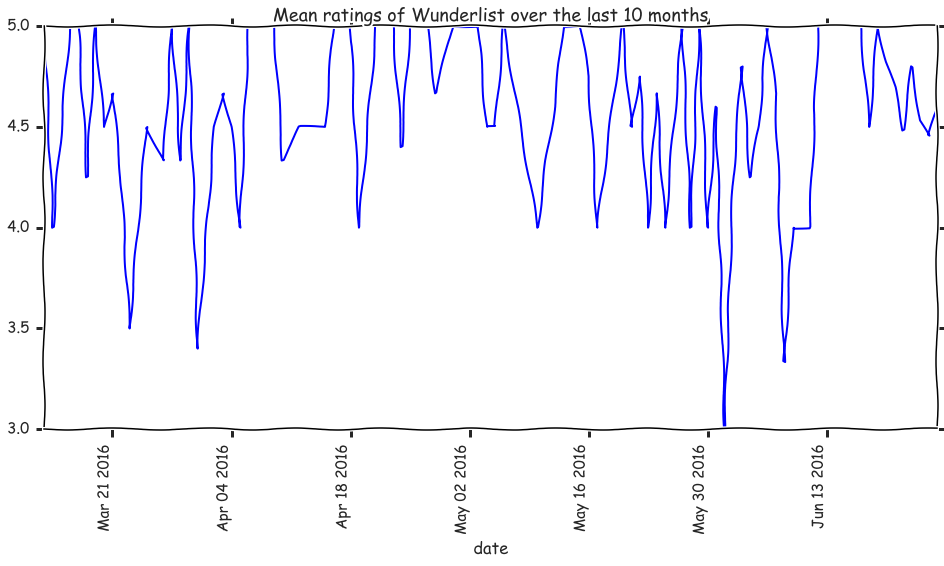

In [14]:
plot_mean_rating_over_last_10_months(wunderlist, "Mean ratings of Wunderlist over the last 10 months")

Pretty good, what about Accomplish?

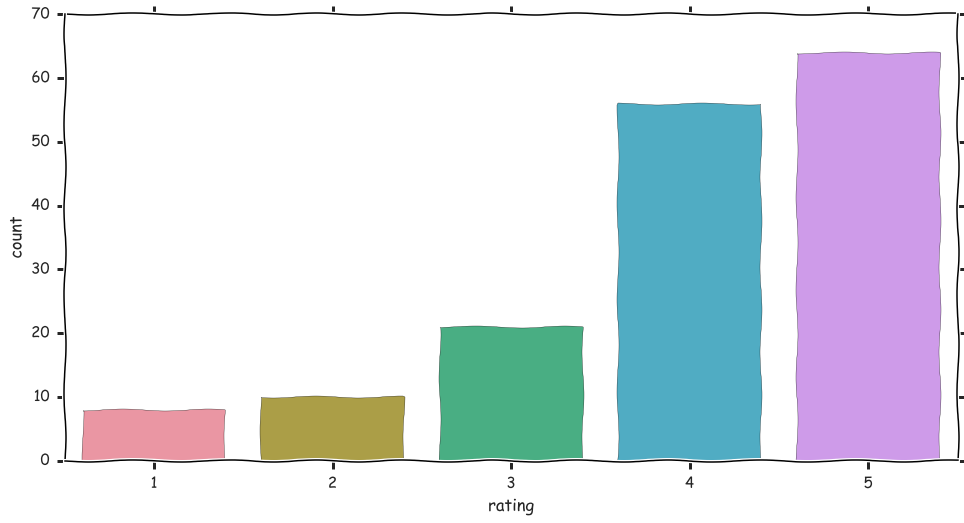

In [15]:
accomlish = df[df.app_package == 'com.accomplish']
sns.countplot(accomlish.rating);

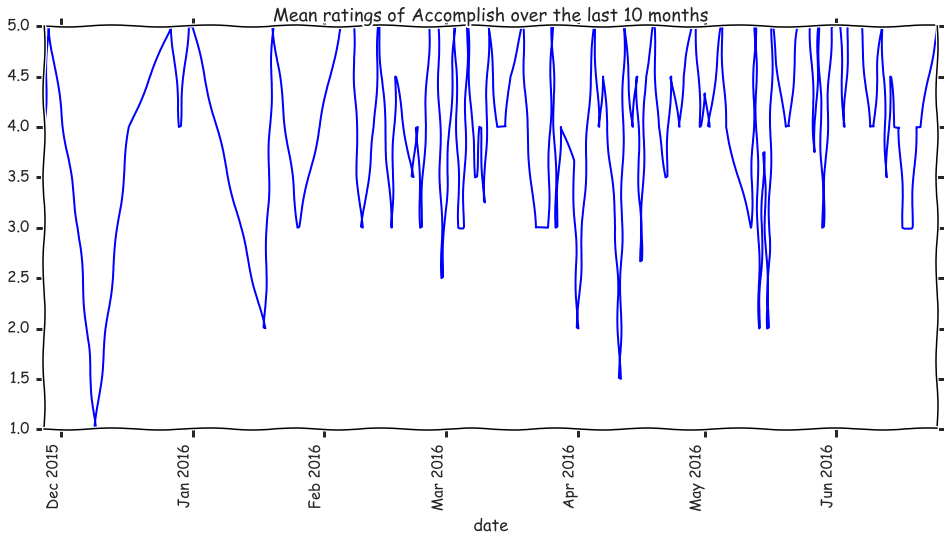

In [16]:
plot_mean_rating_over_last_10_months(accomlish, "Mean ratings of Accomplish over the last 10 months")

Not as great as Wunderlist. Let's take a look of the overall rating distribution in our dataset

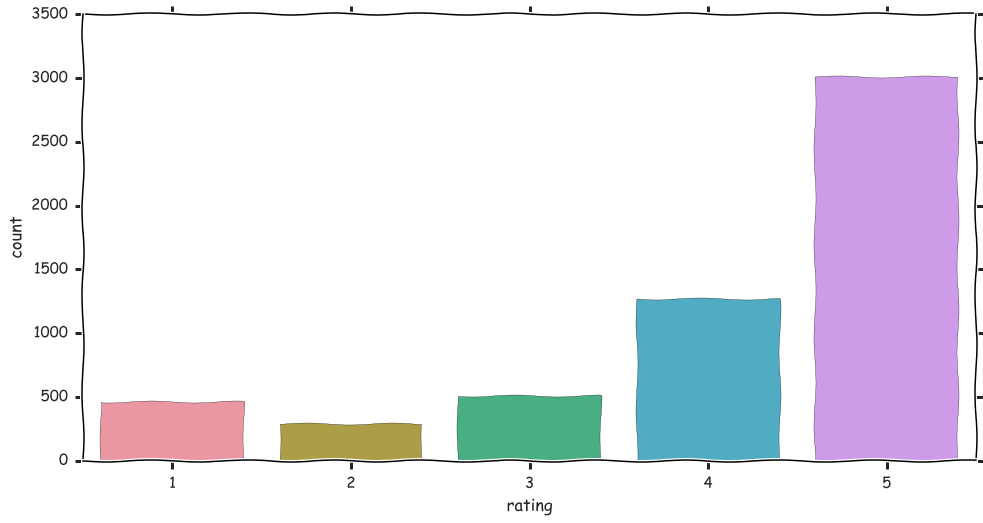

In [17]:
sns.countplot(df.rating);

How does the mean ratings change over time

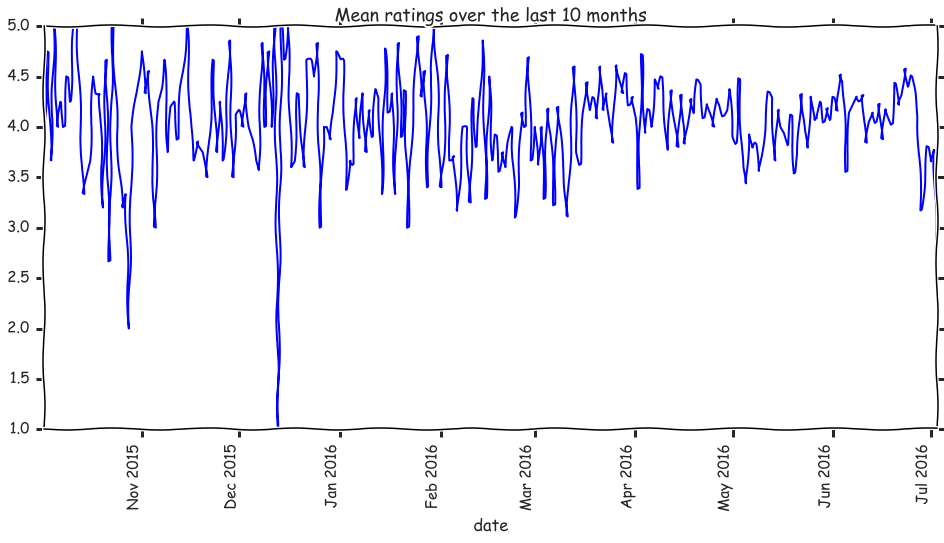

In [18]:
plot_mean_rating_over_last_10_months(df, "Mean ratings over the last 10 months")

It looks like the users have pretty positive opinions about the apps in our dataset. Let's take a look at how the word count per comment are distributed

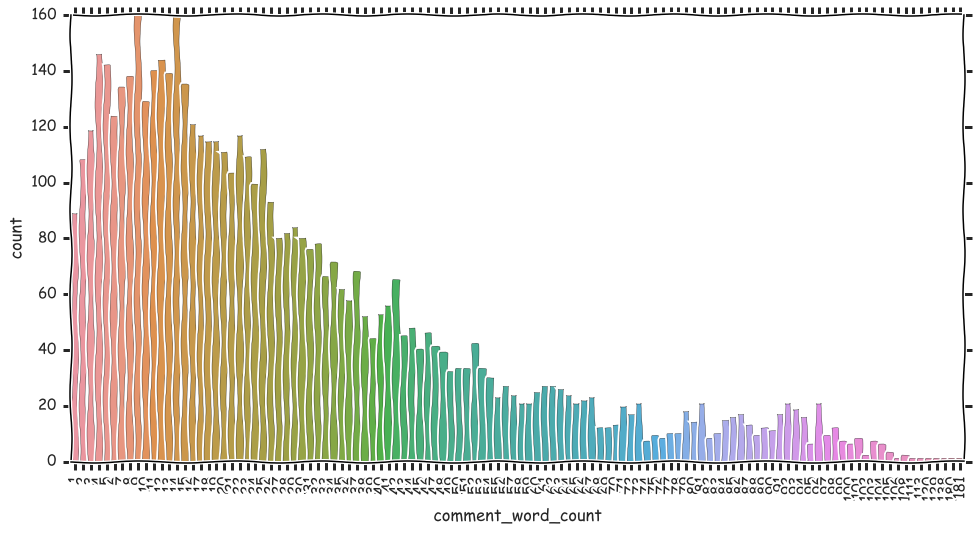

In [19]:
reviews_with_comments = df[df.comment_word_count > 0]
sns.countplot(reviews_with_comments.comment_word_count)
plt.xticks(rotation=90);

Let's take a look at some random positive reviews with more than 50 words

In [20]:
for i, r in df[(df.comment_word_count > 50) & (df.rating > 3)].sample(frac=1)[:10].iterrows():
    print(r.app_package)
    print(r.comment)
    print(r.rating)
    print()

cz.mobilesoft.appblock
The app is amazing. I did the free version and it worked perfectly so I bought the Pro version. I bought a $2.50 bundle of apps from them but only got the single Pro version. Still satisfied but they offered a pop up blocker & other apps. Still the best 2.50 spent!
5

com.pomotodo
This is a fantastic app, well written, very functional and responsive. My only gripe is that everything but the pomodoro screen is fixed in the upright position. When I'm using my tablet as a pomodoro , I have it mounted horizontally. It is somewhat annoying to have to tilt my head to get to the right screen. There would be no disadvantages or clear obstacles if the developers only allowed full functionality of the rotating screen, on all the parts of the pomotodo app.
4

org.withouthat.acalendar
Works well for me. Like the fact that you can read the whole of your event rather than just a section. Find the colour choice a bit limited they all are rather pale and would like to be able to

How does rating and comment word count relate?

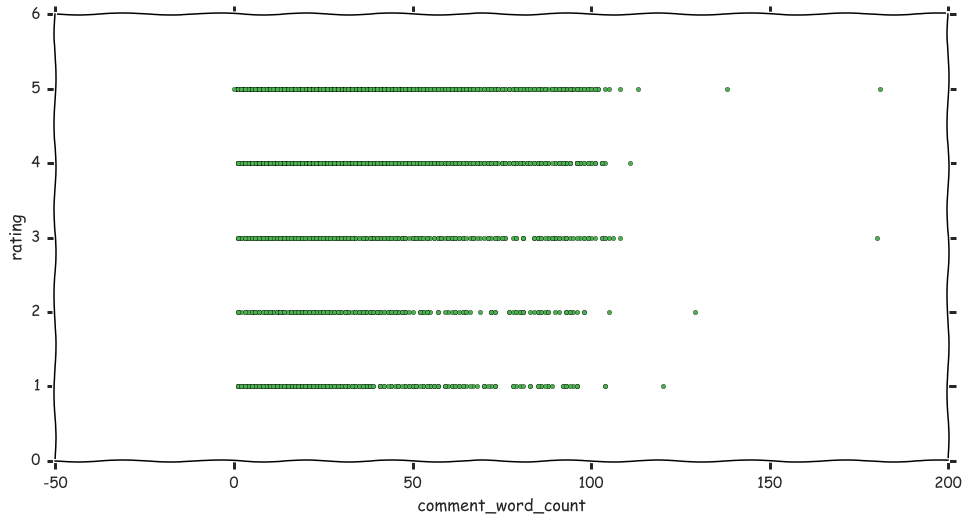

In [21]:
df.plot.scatter('comment_word_count', 'rating');

It looks like positive reviews get more words in their comments. Now let's see some random negative reviews with at least 50 words in their comments

In [22]:
for i, r in df[(df.comment_word_count > 50) & (df.rating < 3)].sample(frac=1)[:10].iterrows():
    print(r.app_package)
    print(r.comment)
    print(r.rating)
    print()

com.superbetter.paid
The app didn't start up. I'm so excited to try this app but it keeps saying that there has been an error due to heavy traffic and to come back again. It's said that for about 2 weeks now. No change has happend. Hope you can a) help me out or b) fix whatever bug this is
1

org.dmfs.tasks
At first I thought my problem was solved - but then the app was supposed to sync regularly, however this did not happen. Now I am uninstalling and using Google Keep to sync between my Android phone and the Mac OS X desktop app. Sorry, this app is not ready for prime time.
2

com.underwood.calendar_beta
Didn't even realize this was only a trial until I opened it one day and it told me I had to buy it. Yes, it turns out it does say this in the description, but only in the part you have to expand to read. Trial apps should state this clearly in the main title.
1

org.withouthat.acalendar
I've been using this app for a few years with good success. Unfortunately recently they decided to 

# Topic modeling using all reviews

In [15]:
from collections import OrderedDict
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

n_features = 1000

stop_words = set(ENGLISH_STOP_WORDS)

nltk_stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
                   'ours', 'ourselves', 'you', 'your', 'yours', 
                   'yourself', 'yourselves', 'he', 'him', 'his', 
                   'himself', 'she', 'her', 'hers', 'herself', 
                   'it', 'its', 'itself', 'they', 'them', 'their', 
                   'theirs', 'themselves', 'what', 'which', 'who', 'whom', 
                   'this', 'that', 'these', 'those', 'am', 'is', 'are', 
                   'was', 'were', 'be', 'been', 'being', 'have', 'has', 
                   'had', 'having', 'do', 'does', 'did', 'doing', 'a', 
                   'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 
                   'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 
                   'against', 'between', 'into', 'through', 'during', 'before', 
                   'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 
                   'out', 'on', 'off', 'over', 'under', 'again', 'further', 
                   'then', 'once', 'here', 'there', 'when', 'where', 'why', 
                   'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
                   'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 
                   'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 
                   'will', 'just', 'don', 'should', 'now']

stop_words |= set(nltk_stop_words)

stop_words.add("app")
stop_words.add("apps")
stop_words.add("ll")
stop_words.add("ve")
stop_words.add("set")
stop_words.add("doesn")

comments = df[df.comment_word_count > 0]

def plot_top_40_words(comments, title = ""):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words=stop_words, lowercase=True)
    tf = vectorizer.fit_transform(comments)
    freqs = {word: tf.getcol(idx).sum() for word, idx in vectorizer.vocabulary_.items()}
    ordered_freqs = OrderedDict(sorted(freqs.items(), key = lambda x: -x[1]))
    ordered_freqs = pd.Series(ordered_freqs)[:40]
    sns.barplot(ordered_freqs.index, ordered_freqs)
    plt.xticks(rotation=90);
    if title:
        plt.title(title);
        
def make_topic_model(comments, n_topics):
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words=stop_words, lowercase=True)
    tf = tf_vectorizer.fit_transform(comments.comment)
    
    lda_tf = LatentDirichletAllocation(n_topics=n_topics, max_iter=500,
                                learning_method='batch', n_jobs=-1,
                                random_state=random_state)
    transformed_res = lda_tf.fit_transform(tf);
    return (transformed_res, pyLDAvis.sklearn.prepare(lda_tf, tf, tf_vectorizer, sort_topics=False))

def print_top_10_reviews_for_topic(topic_n, comments, transformed_res):
    for i, r in enumerate(transformed_res):
        transformed_res[i] /= sum(transformed_res[i])
    column = transformed_res[:, topic_n - 1]
    top_10_indices = list(reversed(column.argpartition(-10)[-10:]))
    for ind in top_10_indices:
        print(comments.iloc[ind].comment)
        print(comments.iloc[ind].app_package)
        print()

Let's take a look at the top 40 most used keywords within the comments

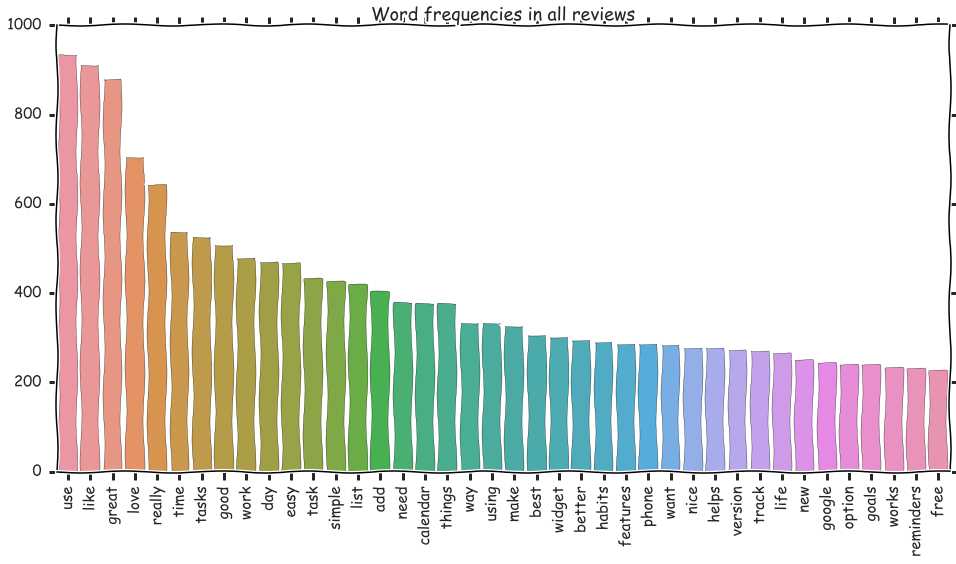

In [24]:
plot_top_40_words(comments.comment, "Word frequencies in all reviews")

In [25]:
transformed_res, model_vis = make_topic_model(comments, 15)
pyLDAvis.display(model_vis)

## What reviews are associated with the first topic?

In [26]:
print_top_10_reviews_for_topic(1, comments, transformed_res)

but Wunderlist is a solid competitor. Some features are for paying customers only, but finally the sync works in free version. The new web interface is stunning!
com.rememberthemilk.MobileRTM

Far more stable than Wuderlist. Much faster than Nozbe. Much more usable than free version of Todoist. Works offline unlike Trello. So far no free soft that I have tried can compete with it.
com.rememberthemilk.MobileRTM

Need this simplicity but also need some improvements by adding some features. One of those is already submitted to developers. Hope it will works 😉
org.dayup.gtask

This was a free app until the last update when it unexpectedly became a trial version, forcing even existing users like myself to pay for the over-priced pro version. Not a fan; uninstalling.
com.underwood.calendar_beta

Service GREAT!  Android app is a bit limited compared to its full web browser version, but it is still good.
com.habitrpg.android.habitica

It was a free app and after the last update it has become a

# Only positive reviews (that is with rating of 4 or 5)

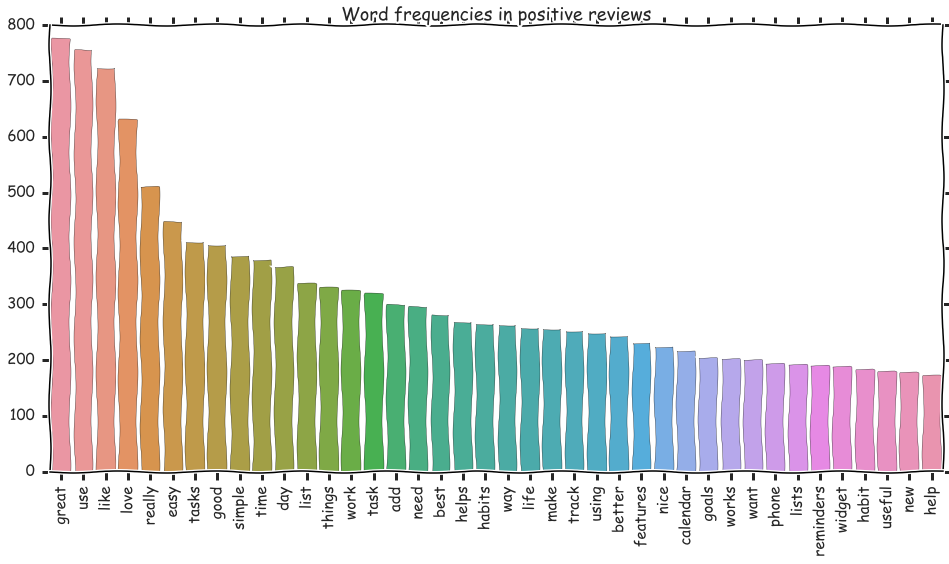

In [27]:
positive_reviews = df[(df.comment_word_count > 0) & (df.rating > 3)]
plot_top_40_words(positive_reviews.comment, "Word frequencies in positive reviews")

In [28]:
transformed_res_positive, model_vis_positive = make_topic_model(positive_reviews, 8)
pyLDAvis.display(model_vis_positive)

## What positive reviews are associated with the first topic?

In [29]:
print_top_10_reviews_for_topic(1, positive_reviews, transformed_res_positive)

the second i think of something i need to do i can quickly enter in the task and then review later what needs to be done. its very satisfying when i complete a task and get to check it off. i wish it kept a history of what i completed just to have a record but thats my only complaint.
com.todoist

Excellent! I wish on the "task list" I can create a group or category and under that group or category are my tasks, e.g business then under that business are my tasks like save for expansion, hire additional resource.. .
org.dmfs.tasks

It can be so hard for me to find a to do list app that does everything I need it to and so far, I'm impressed. No need to assign a due date to a task in order to cross off. Reminds me of tasks when I set reminders. If their not done, I can snooze the task. I'm able to create my own categories and categorize my tasks according to my needs. Tasks can be shared with others, too.
com.codeswitch.tasks

It's great for complex projects/tasks. However, it could be be

# Only negative reviews (that is with rating of 1 or 2)

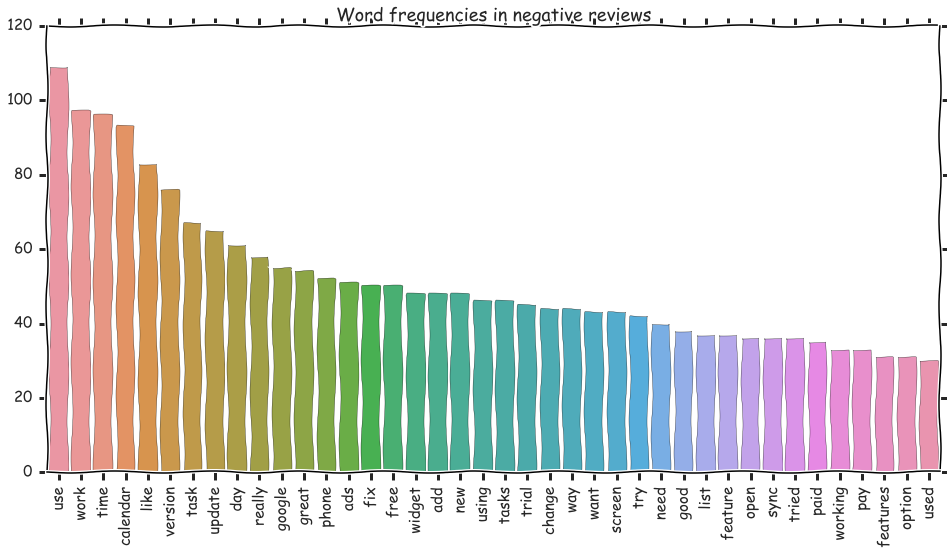

In [30]:
negative_reviews = df[(df.comment_word_count > 0) & (df.rating < 3)]
plot_top_40_words(negative_reviews.comment, "Word frequencies in negative reviews")

In [31]:
transformed_res_negative, model_vis_negative = make_topic_model(negative_reviews, 5)
pyLDAvis.display(model_vis_negative)

## What negative reviews are associated with the first topic?

In [32]:
print_top_10_reviews_for_topic(1, negative_reviews, transformed_res_negative)

I wish I can move a task from one day to a different day by long pressing the task,  then pulling it to the right edge of my screen and have it automatically  travel from day to day until I find the day I want to set it to, at which point I would cease the long-press, and it would drop into the place where I stopped long-pressing. Or: allow me the option to manually set the date/time. It has a lot of potential. Will try it again after next update.
com.accomplish

I'm sorry but this app is a mess.  Really needs to have the beta label on it.  My outlook account repeats like crazy in settings.  I have to scroll quite a bit to even get to select the calendar that accomplish syncs to.  When I edit an existing event accomplish crashes.  Also lacks the ability to zoom in.  It really has potential but it has been a buggy app for some time.  You're better off with time tune app.
com.accomplish

When you wish to delete a recurring reminder that has no end date, you get the option for deleting a 

# Looking for common phrases

In [5]:
reviews = df[df.comment_word_count > 10].comment
positive_reviews = df[(df.comment_word_count > 10) & (df.rating > 3)].comment
negative_reviews = df[(df.comment_word_count > 10) & (df.rating < 3)].comment

def get_words(reviews):
    reviews_text = reviews.str.cat(sep=" ")
    return list(filter(len, reviews_text.split(" ")))

words = get_words(reviews)
pr_words = get_words(positive_reviews)
nr_words = get_words(negative_reviews)

In [189]:
def find_best_collocations(words, keyword="", nbest=10, score_fn=trigram_measures.pmi):
    tf = nltk.collocations.TrigramCollocationFinder.from_words(words)
    tf.apply_freq_filter(3)
    if keyword:
        keyword_filter = lambda *w: keyword not in w
        tf.apply_ngram_filter(keyword_filter)
    return tf.nbest(score_fn, nbest)

In [180]:
find_best_collocations(words)

[('no', 'apparent', 'reason.'),
 ('deserve', '5', 'stars.'),
 ('anyone', 'who', 'wants'),
 ('glasses', 'of', 'water'),
 ('bells', 'and', 'whistles'),
 ('Other', 'than', 'that,'),
 ('across', 'multiple', 'devices.'),
 ("What's", 'the', 'point?'),
 ('My', 'only', 'gripe'),
 ('To', 'Do', 'list')]

In [181]:
find_best_collocations(pr_words)

[('deserve', '5', 'stars.'),
 ('anyone', 'who', 'wants'),
 ('glasses', 'of', 'water'),
 ('5', 'star', 'rating'),
 ('again.', 'And', 'again.'),
 ('Other', 'than', 'that,'),
 ('To', 'Do', 'list'),
 ('bells', 'and', 'whistles'),
 ('Remember', 'the', 'Milk'),
 ('across', 'multiple', 'devices.')]

In [182]:
find_best_collocations(nr_words)

[('no', 'apparent', 'reason.'),
 ('1', 'star', 'down'),
 ('Was', 'great', 'until'),
 ('a', 'deal', 'breaker'),
 ('figure', 'out', 'how'),
 ('full', 'screen', 'ads'),
 ("What's", 'the', 'point?'),
 ("I've", 'been', 'trying'),
 ('Will', 'not', 'let'),
 ('as', 'soon', 'as')]

## Looking for specific keywords

In [134]:
from nltk.corpus import wordnet as wn
import re

In [204]:
def find_synonyms(word):
    synonyms = set()
    for s in wn.synsets(word):
        synonyms |= set(s.lemma_names())
    return synonyms

def print_reviews_containing_word(word):
    pattern = '|'.join(map(re.escape, find_synonyms(word)))
    reviews_with_pattern = reviews.str.lower().str.contains(pattern)
    for r in reviews[reviews_with_pattern].iloc[:10]:
        print(r)
        print()

In [205]:
print_reviews_containing_word('suggestion')

A check list that does more then just check things off with the added bonus of playing in a team. It actually drives me to want to do do my to-do list and improve my real world habits. My subscription is well worth it. The new android updates make it playable on phone just the same as on my computer. I also find the developers are open to suggestions and implement them as soon as they can.

It is pushing me everyday to make my actions turn into habits....one suggestion if it has the negative score to the habits that aren't followed them it would be good.....coz if someone tells me that you can't do it then I want to prove them wrong....

The app is really awesome, has a beautiful design, many features and I can truly recommend to anyone I know. I used many habit tracker apps so I just have a few suggestions of little features  to the badass who develop this app : 1. An extra option/buttons  to select a custom color for the habit,  2. A little less transparency in the "check in" widget.

In [199]:
find_best_collocations(words, keyword="task", nbest=10)

[('a', 'repeating', 'task'),
 ('drag', 'a', 'task'),
 ('stay', 'on', 'task'),
 ('move', 'a', 'task'),
 ('complete', 'a', 'task'),
 ('of', 'task', 'apps'),
 ('the', 'task', 'list'),
 ('the', 'best', 'task'),
 ('list', 'and', 'task'),
 ('a', 'task', 'in')]

In [200]:
find_best_collocations(words, keyword="calendar", nbest=10)

[('with', 'Google', 'calendar'),
 ('a', 'calendar', 'event'),
 ('calendar', 'in', 'Google'),
 ('my', 'Google', 'calendar'),
 ('Google', 'calendar', 'is'),
 ('Google', 'calendar', 'and'),
 ('love', 'this', 'calendar'),
 ('the', 'Google', 'calendar'),
 ('a', 'calendar', 'that'),
 ('calendar', 'app', 'that')]

## Exploring keyphrases using TextRank and word clouds

The [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf) algorithm is unsupervised approach to keyphrase extraction which tries to exploit the structure of the text under consideration. Essentialy it tries to find words that are *central* to the text similar to how PageRank tries to find important pages. The algorithm procedes as follows:

* Separate the text into sentences
* Build matrix of words and the count they appear in each sentence
* Normalize words using tf-idf
* Construct similarity matrix between sentences
* Use PageRank to score the sentences

The implementation used below is taken from [Daniel Preotiuc](https://github.com/danielpreotiuc/textrank). Thanks!

### Keyphrases for all reviews with comment

In [67]:
from wordcloud import WordCloud
from textrank import rank_reviews

def show_cloud(keyphrases, stop_words):
    freqs = [(k, v) for k,v in keyphrases.items() if k not in stop_words]
    wordcloud = WordCloud(background_color="white", max_words=50,
               stopwords=stop_words, max_font_size=28).generate_from_frequencies(freqs)
    
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

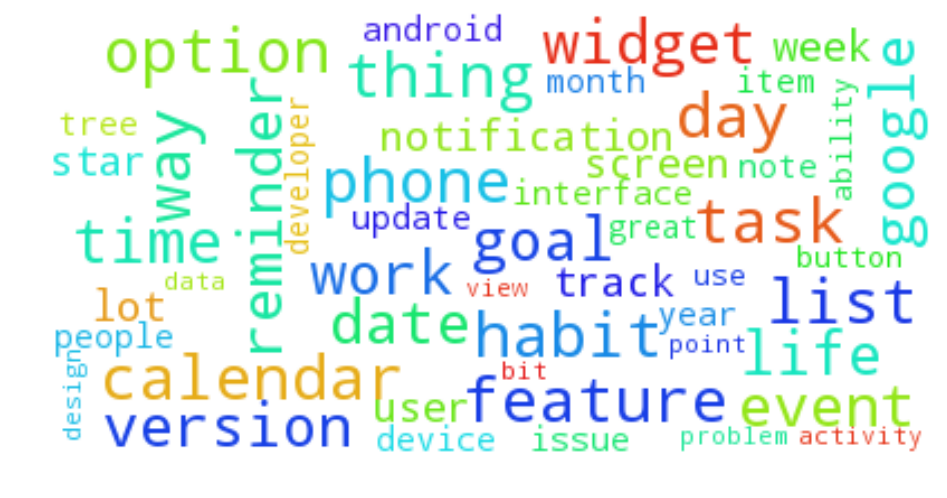

In [68]:
keyphrases = rank_reviews(reviews.values)
show_cloud(keyphrases, stop_words)

### Keyphrases for positive reviews with comment

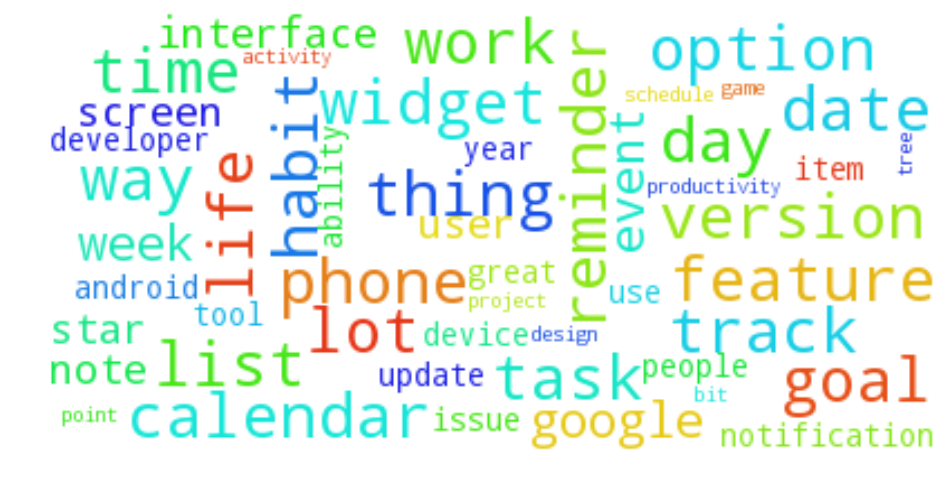

In [69]:
pr_keyphrases = rank_reviews(positive_reviews.values)
show_cloud(pr_keyphrases, stop_words)

### Keyphrases for negative reviews with comment

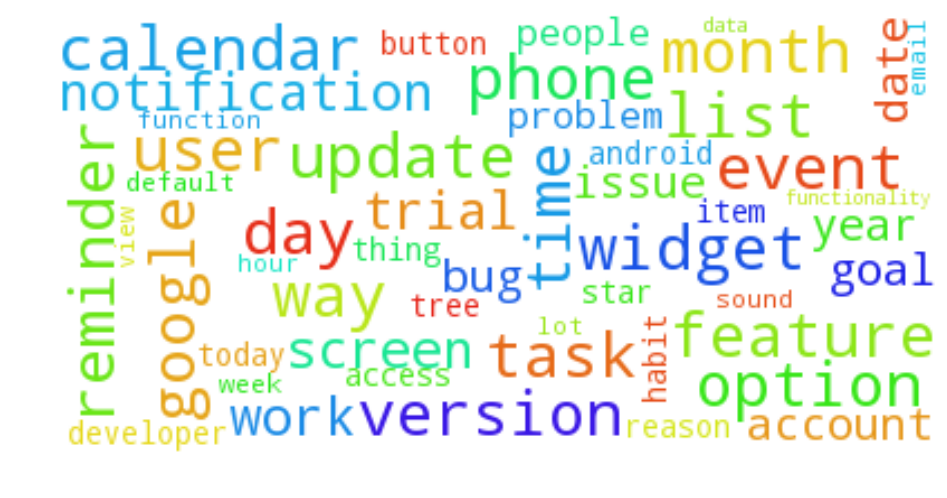

In [70]:
nr_keyphrases = rank_reviews(negative_reviews.values)
show_cloud(nr_keyphrases, stop_words)

Can you go further? What about app descriptions? How are they related to what users are using as keywords/keyphrases? Can you pick some features (reminder, widget or note) and find how often users use it in positive/negative reviews?

# References

* [The original LDA paper](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)
* [Simple enough explanation of LDA](https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/)
* [Topic modeling with latent Dirichlet allocation using Gibbs sampling
 in Python](https://github.com/ariddell/lda)
* [Tutorial on how to use the above package](http://chrisstrelioff.ws/sandbox/2014/11/13/getting_started_with_latent_dirichlet_allocation_in_python.html)
* [Topic extraction in scikit-learn](http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html)
* [Twitter topic modeling in R](https://gist.github.com/bryangoodrich/7b5ef683ce8db592669e)
* [Sentiment analysis of AppStore reviews](http://cs229.stanford.edu/proj2013/CS229-ProjectReport-ChiragSangani-SentimentAnalysisOfAppStoreReviews.pdf)
* [Fine grained sentiment analysis of app reviews](https://mobis.informatik.uni-hamburg.de/wp-content/uploads/2014/06/FeatureSentiments.pdf)
* [Topic modeling and network analysis](http://www.scottbot.net/HIAL/index.html@p=221.html)
* [Collocations in NLTK](http://www.nltk.org/howto/collocations.html)
* [Original TextRank paper](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf)
* [TextRank implementation used above](https://github.com/danielpreotiuc/textrank)